# Development

In [2]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q

In [3]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

directory = os.path.join(os.getcwd(), "baths")
filename = "dominik_bath_small"
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

## Playground

## Random Spin Baths

In [4]:
# Fig. 3 in Dominik's paper (binomial distribution)

rmin, rmax = 0, 1.8e-9
volume = 4/3 * np.pi * (rmax**3 - rmin**3)

a_C = CONST['a_C'] # lattice constant for carbon
V_unit = a_C**3 # volume of the unit cell
N_unit = CONST['N_unit'] # number of carbon atoms per unit cell
n = N_unit/V_unit # density of carbon atoms
N =  int(volume * n) # number of carbon atoms

# Binomial distribution: abundancy is probability of finding a C-13 instead of a C-12
abundancies = np.arange(2, 11) * 0.005e-2
more_than_zero, more_than_one, more_than_two = [], [], []
for abundancy in abundancies: 
    zero_C13 = (1-abundancy)**N
    one_C13 = N * abundancy * (1-abundancy)**(N-1)
    two_C13 = N*(N-1)/2 * abundancy**2 * (1-abundancy)**(N-2)
    more_than_zero.append( 1- zero_C13 )
    more_than_one.append( 1- zero_C13 - one_C13 )
    more_than_two.append( 1- zero_C13 - one_C13 - two_C13 )

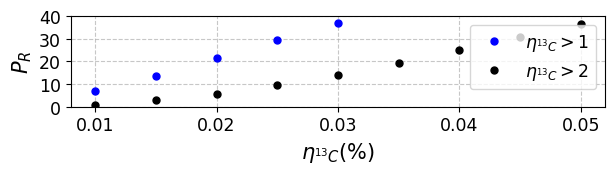

In [5]:
fig, ax = plt.subplots(figsize=(6.4, 4.8//2))

ax.plot(abundancies, more_than_one, 'b.', markersize=10, label=r'$\eta_{^{13}C}>1$')
ax.plot(abundancies, more_than_two, 'k.', markersize=10, label=r'$\eta_{^{13}C}>2$')

# plot settings
ax.set_ylabel(r'$P_R$')
ax.set_xlabel(r'$\eta_{^{13}C} (\%)$')
ax.set_ylim(0, 0.4)
# ax.set_xlim(0.01e-2, 0.05e-2)
ax.legend()
ax.set_xticks([0.01e-2, 0.02e-2, 0.03e-2, 0.04e-2, 0.05e-2], [0.01, 0.02, 0.03, 0.04, 0.05])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4], [0, 10, 20, 30, 40])

plt.show()

## Optimization

In [ ]:
# Optimize pulse sequence 
from scipy.optimize import basinhopping, Bounds

def print_progress(x, f, accepted):
    print(f"Current parameters: {x}, Infidelity: {f}, Accepted: {accepted}")

register_C13_pos = [(0.87e-9, 0, 0.19e-9)] #, (0.56e-9, 0.77e-9, 0.31e-9), (-0.83e-9, 1.15e-9, 0.46e-9)]
bath_spin_type = 'C13'
abundancy, rmin, rmax = 0.02e-2, 2e-9, 4.2e-9
target_state = 1/np.sqrt(2) * (q.tensor(q.fock_dm(2,0), q.fock_dm(2,0)) + q.tensor(q.fock_dm(2,1), q.fock_dm(2,1)) )
init_pulse_seq = [0e-6, 4.06e-6, 1.57e-6, 1.51e-6, 1.00, 3.58, 1.68, 0.69, 1.97, 0.50]

spin_config = SpinConfig(register_C13_pos, bath_spin_type, abundancy, rmin, rmax)
system_configs = spin_config.system_configs['no_bath']

def calc_infidelity(pulse_seq):
    system = System(system_configs, [])
    pulses = Pulses(system, pulse_seq, target_state)
    return 1 - pulses.final_fidelity

basinhopping(
    calc_infidelity, init_pulse_seq, 
    minimizer_kwargs={"method": "L-BFGS-B", "bounds": Bounds([0]*10, [10e-6]*4+[np.pi]*3+[2*np.pi]*3) },
    callback=print_progress, niter=10,
)